# Chinese Dataset

## Import Libs


In [ ]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#plot in jupyter notebook
%matplotlib inline

In [ ]:
#when using colab I like to do this to access the files in drive
#if running in a local pc: 
#           comment this cell
#           change the files' path
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## First Training

### Read Data

Reading the dataset, dropping the *Admission* and *Discharge* times (not important) and then group by *Patient ID*.

In [ ]:
df = pd.read_excel("gdrive/MyDrive/Bolsa - NeuroComp/datasets/time_series_375_prerpocess_en.xlsx",
                   index_col=[0,1])
df = df.drop(columns=['Admission time', 'Discharge time']) #info not important
df = df.groupby('PATIENT_ID').first()

df.head()

,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,73,1,0,19.9,136.0,103.1,13.9,0.09,0.6,NaN,46.0,33.3,0.3,NaN,8.3,105.0,10.7,NaN,NaN,4.3,11.9,65.8,69.3,0.05,91.0,0.03,91.8,39.2,3.54,NaN,347.0,3.28,NaN,8.5,0.80,7.415,4.27,0.02,2.29,4.33,7.35,2.33,4.0,11.9,634.9,40.8,19.2,22.6,0.06,2.20,3.90,33.0,418.0,21.2,2.02,60.0,306.0,39.9,NaN,NaN,0.38,16.3,36.0,24.0,1.06,0.01,-1.0,31.9,37.9,43.1,0.09,137.7,0.12,41.0,16.0,46.6,130.0
2,61,1,0,16.9,135.0,99.9,14.3,0.09,0.0,1152.0,33.0,35.3,0.1,35.9,9.1,290.0,3.2,NaN,29.6,4.9,12.1,89.2,70.5,0.06,87.0,0.00,90.8,38.4,7.46,12.3,352.0,5.58,5.0,6.1,0.56,6.000,4.23,0.00,2.49,4.78,5.91,6.65,4.2,10.4,1512.9,39.8,17.0,7.5,0.10,0.96,3.57,77.0,178.0,21.7,2.26,173.0,738.0,27.5,68.24,NaN,0.24,11.9,35.2,41.0,1.09,0.01,-1.0,31.9,42.3,27.4,NaN,138.2,0.30,40.0,38.0,81.3,88.0
3,70,2,0,NaN,109.0,99.1,13.6,0.06,0.0,591.0,47.0,34.9,0.0,8.1,7.5,169.0,5.9,84.0,21.9,3.8,12.8,75.0,68.3,0.07,94.0,0.01,94.6,33.2,3.72,10.4,328.0,5.33,5.0,2.9,0.71,NaN,3.51,0.00,2.17,3.34,9.02,2.79,3.7,11.6,567.2,44.4,16.7,19.1,0.06,0.98,3.28,30.0,151.0,22.3,2.07,NaN,328.0,37.8,47.82,4.0,0.22,13.9,33.4,21.0,1.04,0.00,-1.0,31.1,34.8,42.3,0.10,135.7,0.20,66.0,19.0,77.2,69.0
4,74,1,0,4.8,84.0,100.8,16.3,0.38,1.5,NaN,66.0,33.9,0.2,NaN,15.5,94.0,3.8,NaN,NaN,7.0,11.3,82.0,65.3,0.04,68.0,0.00,118.9,22.6,5.99,NaN,372.0,NaN,NaN,7.5,0.75,6.000,1.90,0.09,2.34,3.84,5.77,4.91,8.5,10.5,NaN,49.4,NaN,12.5,0.06,1.26,2.56,27.0,250.0,22.8,2.08,152.0,338.0,28.5,NaN,NaN,0.23,11.2,31.4,15.0,1.29,0.01,-1.0,44.2,NaN,108.2,0.11,137.9,0.10,72.0,20.0,82.0,81.0
5,29,2,0,5.6,120.0,99.7,14.6,0.02,0.2,258.0,78.0,40.2,0.2,5.0,3.5,215.0,6.8,NaN,16.6,1.6,12.5,54.9,70.3,0.05,83.0,0.01,86.8,34.9,4.43,11.1,344.0,NaN,16.4,2.3,1.68,6.000,4.02,0.01,2.26,3.26,5.34,2.43,1.9,10.3,121.1,40.0,NaN,37.9,0.05,0.42,2.49,24.0,302.0,25.6,2.12,5.0,195.0,26.7,1.50,NaN,0.30,11.4,30.1,19.0,1.13,0.01,-1.0,29.9,NaN,7.0,0.08,140.2,0.22,15.0,12.0,120.0,58.0


Fiding NaN values in my dataset

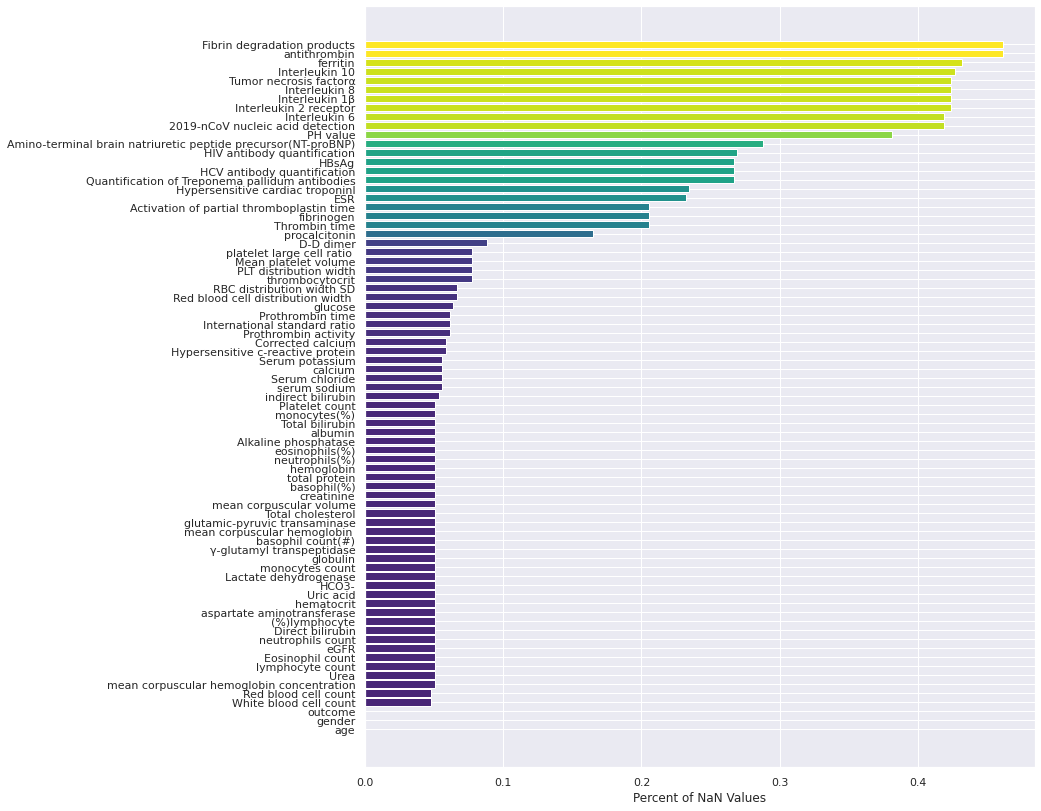

In [ ]:
#find NaN values
miss_data = df.isna().mean().sort_values(ascending=True) 

#color func
my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

#plot 
fig, ax = plt.subplots(figsize=(12, 14))

#ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Percent of NaN Values')
plt.barh(miss_data.index, miss_data, color=my_cmap(rescale(miss_data)))

plt.show()

We're gonne use only data with less than 20% of NaN values (darker ones)

In [ ]:
nan_value = 0.2 #percent of NaN values
sel_col = df.columns[(df.isna().mean() <= nan_value).values]

#df[sel_col].head()

### Separating Values

Separating the data set in features e results

In [ ]:
X = df.drop(columns=["outcome"]) #labels - drop outcome (feature)
y = df.outcome #feature - dead or alive 

import_feature = pd.DataFrame(columns=X.columns)

In [ ]:
X.head(100)

,age,gender,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,73,1,19.9,136.0,103.1,13.9,0.09,0.6,NaN,46.0,33.3,0.3,NaN,8.3,105.0,10.7,NaN,NaN,4.3,11.9,65.8,69.3,0.05,91.0,0.03,91.8,39.2,3.54,NaN,347.0,3.28,NaN,8.5,0.80,7.415,4.27,0.02,2.29,4.33,7.35,2.33,4.0,11.9,634.9,40.8,19.2,22.6,0.06,2.20,3.90,33.0,418.0,21.2,2.02,60.0,306.0,39.9,NaN,NaN,0.38,16.3,36.0,24.0,1.06,0.01,-1.0,31.9,37.9,43.1,0.09,137.7,0.12,41.0,16.0,46.6,130.0
2,61,1,16.9,135.0,99.9,14.3,0.09,0.0,1152.0,33.0,35.3,0.1,35.9,9.1,290.0,3.2,NaN,29.6,4.9,12.1,89.2,70.5,0.06,87.0,0.00,90.8,38.4,7.46,12.3,352.0,5.58,5.0,6.1,0.56,6.000,4.23,0.00,2.49,4.78,5.91,6.65,4.2,10.4,1512.9,39.8,17.0,7.5,0.10,0.96,3.57,77.0,178.0,21.7,2.26,173.0,738.0,27.5,68.24,NaN,0.24,11.9,35.2,41.0,1.09,0.01,-1.0,31.9,42.3,27.4,NaN,138.2,0.30,40.0,38.0,81.3,88.0
3,70,2,NaN,109.0,99.1,13.6,0.06,0.0,591.0,47.0,34.9,0.0,8.1,7.5,169.0,5.9,84.0,21.9,3.8,12.8,75.0,68.3,0.07,94.0,0.01,94.6,33.2,3.72,10.4,328.0,5.33,5.0,2.9,0.71,NaN,3.51,0.00,2.17,3.34,9.02,2.79,3.7,11.6,567.2,44.4,16.7,19.1,0.06,0.98,3.28,30.0,151.0,22.3,2.07,NaN,328.0,37.8,47.82,4.0,0.22,13.9,33.4,21.0,1.04,0.00,-1.0,31.1,34.8,42.3,0.10,135.7,0.20,66.0,19.0,77.2,69.0
4,74,1,4.8,84.0,100.8,16.3,0.38,1.5,NaN,66.0,33.9,0.2,NaN,15.5,94.0,3.8,NaN,NaN,7.0,11.3,82.0,65.3,0.04,68.0,0.00,118.9,22.6,5.99,NaN,372.0,NaN,NaN,7.5,0.75,6.000,1.90,0.09,2.34,3.84,5.77,4.91,8.5,10.5,NaN,49.4,NaN,12.5,0.06,1.26,2.56,27.0,250.0,22.8,2.08,152.0,338.0,28.5,NaN,NaN,0.23,11.2,31.4,15.0,1.29,0.01,-1.0,44.2,NaN,108.2,0.11,137.9,0.10,72.0,20.0,82.0,81.0
5,29,2,5.6,120.0,99.7,14.6,0.02,0.2,258.0,78.0,40.2,0.2,5.0,3.5,215.0,6.8,NaN,16.6,1.6,12.5,54.9,70.3,0.05,83.0,0.01,86.8,34.9,4.43,11.1,344.0,NaN,16.4,2.3,1.68,6.000,4.02,0.01,2.26,3.26,5.34,2.43,1.9,10.3,121.1,40.0,NaN,37.9,0.05,0.42,2.49,24.0,302.0,25.6,2.12,5.0,195.0,26.7,1.50,NaN,0.30,11.4,30.1,19.0,1.13,0.01,-1.0,29.9,NaN,7.0,0.08,140.2,0.22,15.0,12.0,120.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,66,1,2.2,135.0,93.5,14.8,0.05,0.0,348.0,75.0,35.1,0.0,5.0,6.7,129.0,9.2,NaN,13.2,4.2,12.2,75.5,65.3,0.06,81.0,56.32,91.3,38.9,4.45,5.8,347.0,4.28,5.0,4.6,0.68,NaN,4.26,0.00,2.22,3.96,6.92,3.36,2.5,10.5,284.6,39.7,15.0,15.3,0.09,0.36,3.47,24.0,186.0,22.6,1.98,26.0,177.0,29.2,21.08,NaN,0.41,11.6,30.2,28.0,1.15,0.0

### Training

XGBoost Read the Docs [[4]](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [ ]:
tmax = 500 #100, 150, 200

for i in range(tmax): 
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=i) #state for iteration
    
    model = XGBClassifier(max_depth=4, #Maximum tree depth for base learners.
                          learning_rate=0.2, #Boosting learning rate (xgb’s “eta”)
                          reg_lambda=1, #L2 regularization term on weights
                          n_estimators=150, #Number of boosting rounds.
                          subsample = 0.9, #Subsample ratio of the training instance.
                          colsample_bytree = 0.9) #Subsample ratio of columns when constructing each tree.
    
    model.fit(X_train, y_train)
    import_feature = import_feature.append(pd.DataFrame(model.feature_importances_,
                                                        index=X.columns).transpose())

X_best = X[import_feature.mean().sort_values(ascending=False).head(5).index]

In [ ]:
X_best.head()

,Lactate dehydrogenase,neutrophils(%),(%)lymphocyte,procalcitonin,neutrophils count
PATIENT_ID,,,,,
1,306.0,65.8,22.6,0.09,2.33
2,738.0,89.2,7.5,0.09,6.65
3,328.0,75.0,19.1,0.06,2.79
4,338.0,82.0,12.5,0.38,4.91
5,195.0,54.9,37.9,0.02,2.43


### Evaluate Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_best, #x = x_best
                                                    y, #same
                                                    test_size=0.3, #same
                                                    random_state=3463) #def state

model = XGBClassifier(max_depth=4,
                      learning_rate=0.2,
                      reg_lambda=1,
                      n_estimators=150,
                      subsample=0.9,
                      colsample_bytree=0.9,
                      verbosity=0)

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=0)

### Predicting

In [ ]:
predict_labels = model.predict(X_test)
c_matrix = confusion_matrix(y_test, predict_labels)

### Confusion Matrix

making a confusion matrix

plotting the confusion matrix more visible

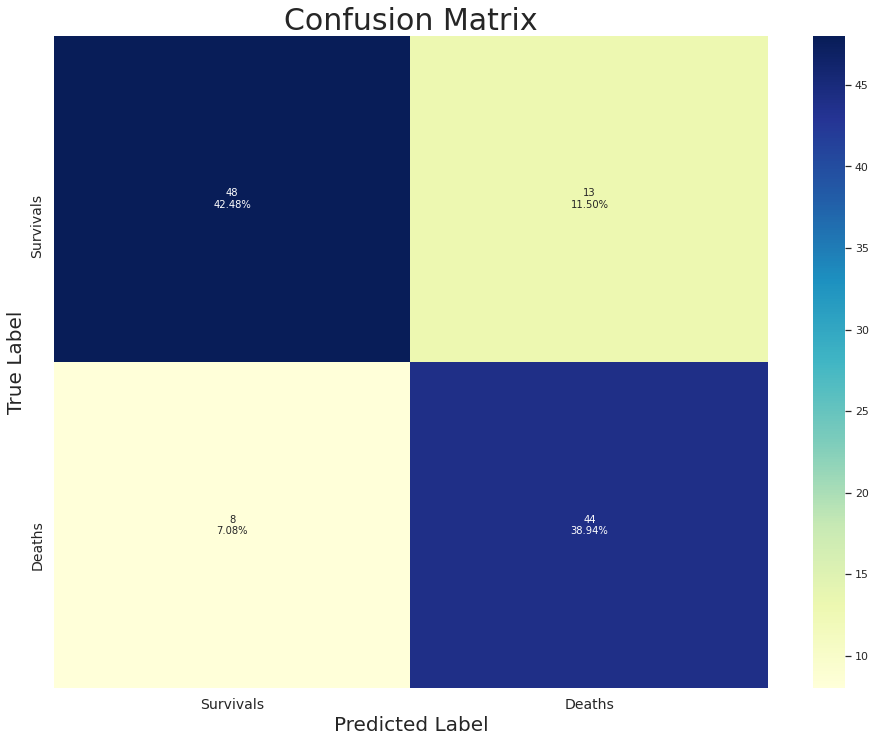

In [ ]:
#making labels
group_counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten()/np.sum(c_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#plot
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(c_matrix, annot=labels, fmt='', cmap="YlGnBu")#, cmap='Blues', cbar=True)

#axis labels
ticks_labels = ['Survivals', 'Deaths']
plt.xticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)
plt.yticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)

plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)

#title
plt.title('Confusion Matrix', fontsize=30)

#show
plt.show()

### Model Reliability  (I guess?)

F-score in wiki [here](https://en.wikipedia.org/wiki/F-score).

In [ ]:
f1_score(y_test, predict_labels)

0.8073394495412844

## Second Training

### Read Data

NLR = Neutrophil to Lymphocyte Ratio [[5]](https://en.wikipedia.org/wiki/Neutrophil_to_lymphocyte_ratio)

In [ ]:
#same thing as done before
df2 = pd.read_excel("gdrive/MyDrive/Bolsa - NeuroComp/datasets/time_series_375_prerpocess_en.xlsx",
                    index_col=[0,1])
df2 = df2.drop(columns=['Admission time', 'Discharge time'])
df2 = df2.groupby('PATIENT_ID').first()

nan_value = 0.2 #percent of NaN values
sel_col2 = df2.columns[(df2.isna().mean() <= nan_value).values]
df2 = df2[sel_col2]

#??????? drop some random labels ??????
df2["NLR"] = df2['neutrophils count'] / df2['lymphocyte count'] #??????
df2.drop(labels=['lymphocyte count', #l34
                 'neutrophils count', #l41
                 'neutrophils(%)', #l21
                 '(%)lymphocyte'], #l47
         axis=1,
         inplace=True)

In [ ]:
df2.head() 

,age,gender,outcome,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Alkaline phosphatase,albumin,basophil(%),Total bilirubin,Platelet count,monocytes(%),indirect bilirubin,Red blood cell distribution width,total protein,Prothrombin activity,mean corpuscular volume,hematocrit,White blood cell count,mean corpuscular hemoglobin concentration,Urea,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,Direct bilirubin,Mean platelet volume,RBC distribution width SD,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Lactate dehydrogenase,platelet large cell ratio,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),mean corpuscular hemoglobin,Hypersensitive c-reactive protein,serum sodium,thrombocytocrit,glutamic-pyruvic transaminase,eGFR,creatinine,NLR
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,73,1,0,136.0,103.1,13.9,0.09,0.6,46.0,33.3,0.3,8.3,105.0,10.7,4.3,11.9,69.3,91.0,91.8,39.2,3.54,347.0,8.5,4.27,0.02,2.29,4.33,7.35,4.0,11.9,40.8,2.20,3.90,33.0,418.0,21.2,2.02,306.0,39.9,0.38,16.3,36.0,24.0,1.06,0.01,31.9,43.1,137.7,0.12,16.0,46.6,130.0,2.912500
2,61,1,0,135.0,99.9,14.3,0.09,0.0,33.0,35.3,0.1,9.1,290.0,3.2,4.9,12.1,70.5,87.0,90.8,38.4,7.46,352.0,6.1,4.23,0.00,2.49,4.78,5.91,4.2,10.4,39.8,0.96,3.57,77.0,178.0,21.7,2.26,738.0,27.5,0.24,11.9,35.2,41.0,1.09,0.01,31.9,27.4,138.2,0.30,38.0,81.3,88.0,11.875000
3,70,2,0,109.0,99.1,13.6,0.06,0.0,47.0,34.9,0.0,7.5,169.0,5.9,3.8,12.8,68.3,94.0,94.6,33.2,3.72,328.0,2.9,3.51,0.00,2.17,3.34,9.02,3.7,11.6,44.4,0.98,3.28,30.0,151.0,22.3,2.07,328.0,37.8,0.22,13.9,33.4,21.0,1.04,0.00,31.1,42.3,135.7,0.20,19.0,77.2,69.0,3.929577
4,74,1,0,84.0,100.8,16.3,0.38,1.5,66.0,33.9,0.2,15.5,94.0,3.8,7.0,11.3,65.3,68.0,118.9,22.6,5.99,372.0,7.5,1.90,0.09,2.34,3.84,5.77,8.5,10.5,49.4,1.26,2.56,27.0,250.0,22.8,2.08,338.0,28.5,0.23,11.2,31.4,15.0,1.29,0.01,44.2,108.2,137.9,0.10,20.0,82.0,81.0,6.546667
5,29,2,0,120.0,99.7,14.6,0.02,0.2,78.0,40.2,0.2,3.5,215.0,6.8,1.6,12.5,70.3,83.0,86.8,34.9,4.43,344.0,2.3,4.02,0.01,2.26,3.26,5.34,1.9,10.3,40.0,0.42,2.49,24.0,302.0,25.6,2.12,195.0,26.7,0.30,11.4,30.1,19.0,1.13,0.01,29.9,7.0,140.2,0.22,12.0,120.0,58.0,1.446429


### Separating Values

In [ ]:
X2 = df2.drop(columns=["outcome"])
y2 = df2.outcome

import_feature2 = pd.DataFrame(columns=X2.columns)

### Training

In [ ]:
tmax = 50 #100, 150, 200

for i in range(tmax):
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                            y2,
                                                            test_size=0.3,
                                                            random_state=i) #state for iteration
    
    model2 = XGBClassifier(max_depth=4,
                           learning_rate=0.2,
                           reg_lambda=1,
                           n_estimators=150,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           verbosity=0)
    
    model2.fit(X2_train, y2_train)
    import_feature2 = import_feature2.append(pd.DataFrame(model2.feature_importances_,
                                                          index=X2.columns).transpose())

In [ ]:
X2_best = X2[import_feature2.mean().sort_values(ascending=False).head(5).index]
X2_best

,Lactate dehydrogenase,NLR,procalcitonin,Hypersensitive c-reactive protein,D-D dimer
PATIENT_ID,,,,,
1,306.0,2.912500,0.09,43.1,2.20
2,738.0,11.875000,0.09,27.4,0.96
3,328.0,3.929577,0.06,42.3,0.98
4,338.0,6.546667,0.38,108.2,1.26
5,195.0,1.446429,0.02,7.0,0.42
...,...,...,...,...,...
371,573.0,5.285714,1.51,152.0,2.57
372,276.0,59.476190,2.13,320.0,1.21
373,702.0,14.210526,0.56,205.8,NaN


In [ ]:
pd.DataFrame(import_feature2.mean().sort_values(ascending=False).head(15))

,0
Lactate dehydrogenase,0.208636
NLR,0.078702
procalcitonin,0.060242
Hypersensitive c-reactive protein,0.038513
D-D dimer,0.036163
Prothrombin time,0.025765
Urea,0.024415
White blood cell count,0.024037
thrombocytocrit,0.019457
Prothrombin activity,0.018862


### Evaluate Model

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_best,
                                                        y2,
                                                        test_size=0.3,
                                                        random_state=3463)

model2 = XGBClassifier(max_depth=4,
                       learning_rate=0.2,
                       reg_lambda=1,
                       n_estimators=150,
                       subsample = 0.9,
                       colsample_bytree = 0.9)

model2.fit(X2_train, y2_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

### Predicting

In [ ]:
predict_labels2 = model2.predict(X2_test)
c_matrix2 = confusion_matrix(y2_test, predict_labels2)

### Confusion Matrix

making confusion matrix more visible

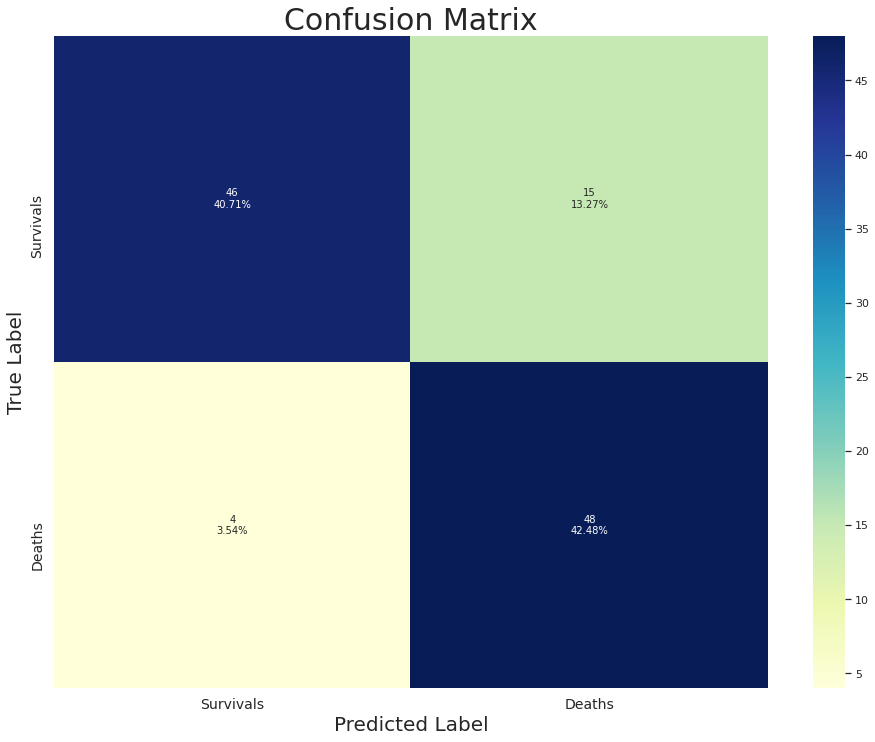

In [ ]:
#making labels
group_counts = ['{0:0.0f}'.format(value) for value in c_matrix2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in c_matrix2.flatten()/np.sum(c_matrix2)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#plot
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(c_matrix2, annot=labels, fmt='', cmap="YlGnBu")#, cmap='Blues', cbar=True)

#axis labels
ticks_labels = ['Survivals', 'Deaths']
plt.xticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)
plt.yticks(np.arange(2) + .5, labels=ticks_labels, fontsize=14)

plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)

#title
plt.title('Confusion Matrix', fontsize=30)

#show
plt.show()

### Model Reliability

In [ ]:
f1_score(y_test, predict_labels)

0.8073394495412844

## BoxPlots

### NLR of Dead or Alive

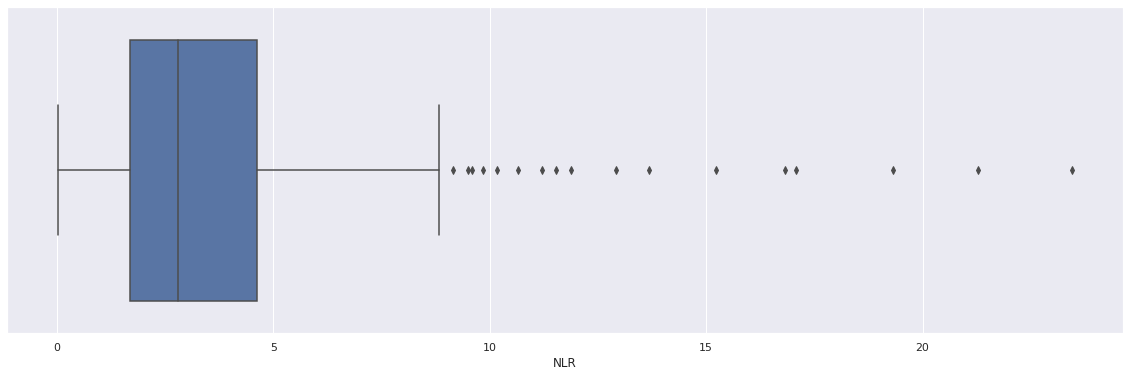

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(df2[df2.outcome == 0].NLR, color="b")

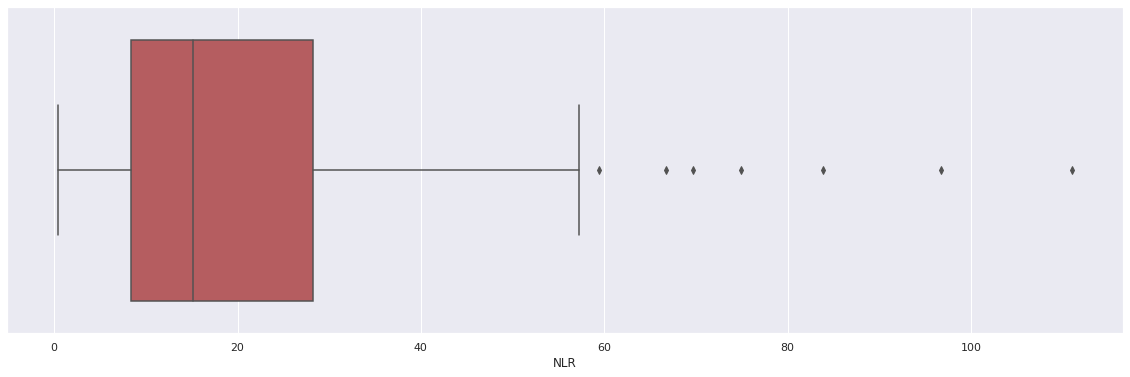

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(df2[df2.outcome == 1].NLR, color="r")

### Hypersensitive C-Reative Protein

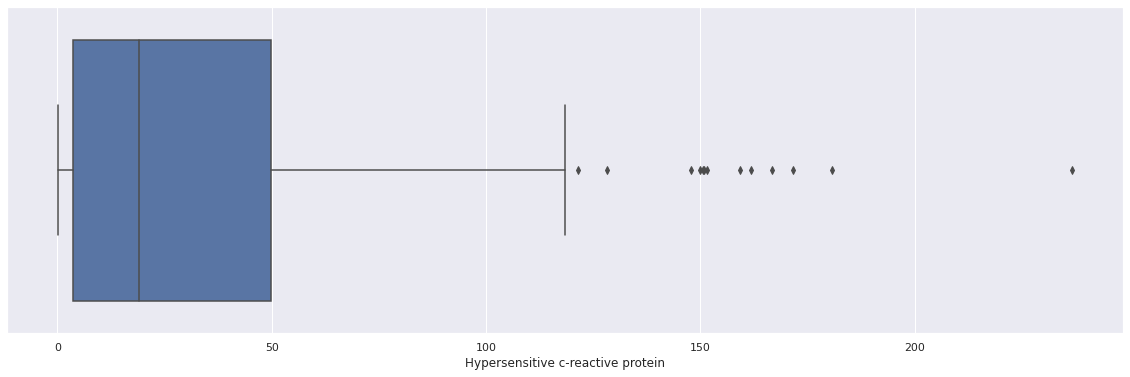

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(df[df.outcome == 0]["Hypersensitive c-reactive protein"], color="b")

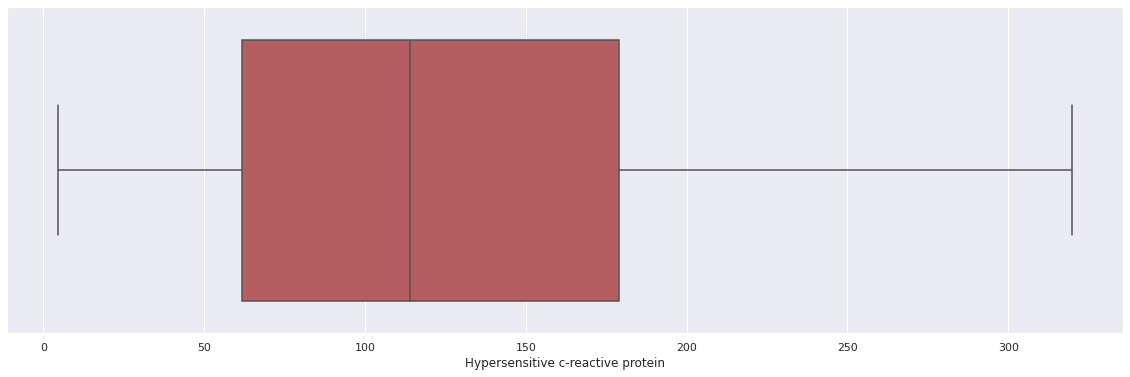

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(df[df.outcome == 1]["Hypersensitive c-reactive protein"], color="r")